## Notebook 1 for System Biology of Aging 
This notebook is part of the first session of the 2024 Systems Biology of Aging Workshop. But don't worry about setup, all of the files and R packages should be preinstalled in the the Sagemaker environment.

This Notebook will use the "custom-R" kernel. Double check that this is correct by looking in the top right corner.


Does this need to be copyied and saved? 
Do we want to link to anything? 
Any disclaimers?


> Creating a final Notebook 1
> TODO:
> * Change inital Notebook to R
> * Time cells and generate any output that needs to be loaded
> * Update all links for Sagemaker directory

> Outline
> * Data exploration and cleaning
> ** Dispersion of frailty measures
> ** Create baseline proteins, metabolites and clinical
> * Dimensionality reduction
> ** Scale and impute for PCA
> * Single-Omics DE
> ** DE of Proteins and Metabolites quintiles
> ** Volcano plots
> ** Enrichment
> * Single-Omic WGNCA
> ** Correlate with frailty
> ** Enrichment of select modules
> * Multi-Omic WGCNA
> ** Correlate with frailty
> ** Multiomic ssgsea????

## Setup
The next couple blocks of code will load the R packages into our notebook and set some options for prettier visualizaions.

In [72]:
# Load packages, one per line for clarity
library("tidyverse", quietly = TRUE, warn.conflicts=FALSE)
library("ggplot2", quietly = TRUE, warn.conflicts=FALSE)
suppressMessages(library("WGCNA", quietly = TRUE, warn.conflicts=FALSE))
library("org.Hs.eg.db")
library("GO.db")
library("clusterProfiler")
library( "enrichplot")
library("limma")
library("DT")

ERROR: Error in library("ggpubr"): there is no package called ‘ggpubr’


In [55]:
# Other options
source("Scripts/Workshop_scripts.R") # Functions for plotting
options(stringsAsFactors=FALSE)#Required for WGCNA
enableWGCNAThreads(nThreads=2) # 
options(repr.plot.width=7, repr.plot.height=7)#Default=7x7
options(warn=-1)

Allowing parallel execution with up to 2 working processes.


# Let's Get Started!

Now that our environment is ready, let's start digging into our data. In the data folder you should see a bunch of tsv files. We'll go through all of these over the course of the anlaysis, but let's start by looking at our outcome, the frailty indices.

In [33]:
fr_measures = read_delim("/shared-libs/useful-files/frailty_measures_kanelab/FI_workshop_040124/combination_fi_040124.csv", show_col_types = FALSE, delim=",")
dim(fr_measures)
head(fr_measures)

New names:
• `` -> `...1`


[1] 3090   83

...1,public_client_id,self_fi,self_fi_sum,num_na_self,days_in_program,sex,age,race,Dise1,⋯,BP1,BP2,BP3,BP4,BP5,num_na_lab,lab_fi,lab_fi_sum,num_na_both,merge_fi
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,01001548,0.18857143,6.6,0,4,M,49,white,0,⋯,1,1,NA,1,0,1,0.36363636,12,1,0.27352941
2,01002192,0.11428571,4.0,0,0,M,26,white,0,⋯,1,1,NA,1,0,1,0.27272727,9,1,0.19117647
3,01003555,0.15757576,5.2,2,0,M,47,white,0,⋯,1,1,NA,1,0,1,0.33333333,11,3,0.24545454
4,01003662,0.16285714,5.7,0,1,M,26,white,0,⋯,0,1,NA,0,0,1,0.27272727,9,1,0.21617647
5,01006695,0.16000000,5.6,0,0,M,61,white,0,⋯,0,0,NA,0,0,1,0.03030303,1,1,0.09705882
6,01007032,0.07428571,2.6,0,0,M,48,ashkenazi jewish,0,⋯,0,1,NA,0,0,1,0.18181818,6,1,0.12647059


To see the number of timepoints of the frailty index, we look at the frequency tables of the participants.

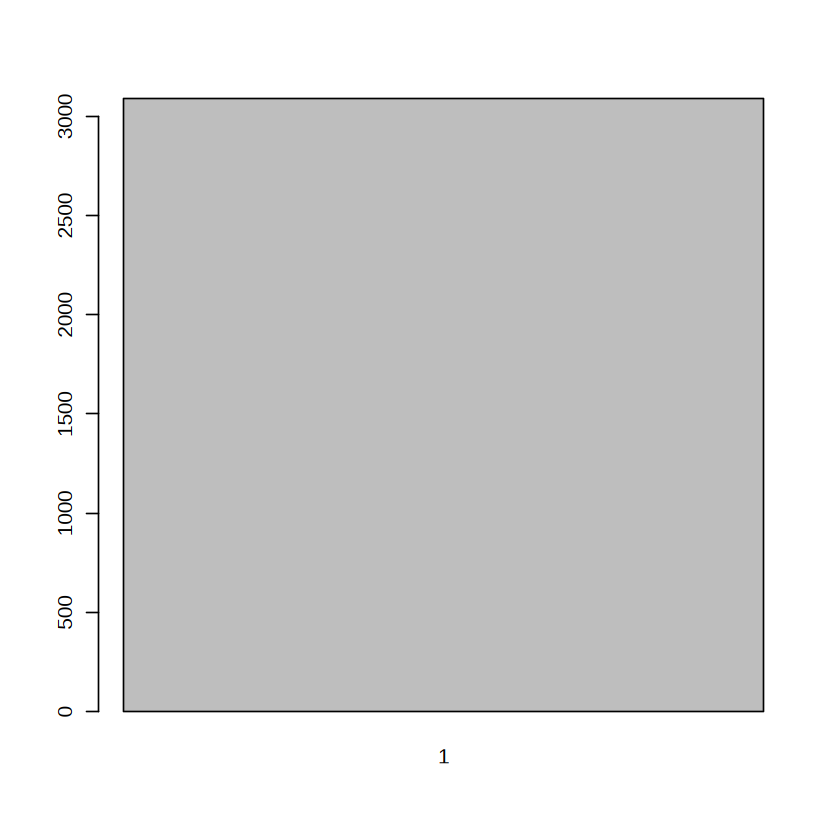

In [38]:
barplot(table(table(fr_measures$public_client_id)))

So its a boring plot- but we can see that frailty was only calculated at 1 timepoint for each participant. Looking a bit closer, we see that this was the closest timepoint to the blood draw for the omics samples.

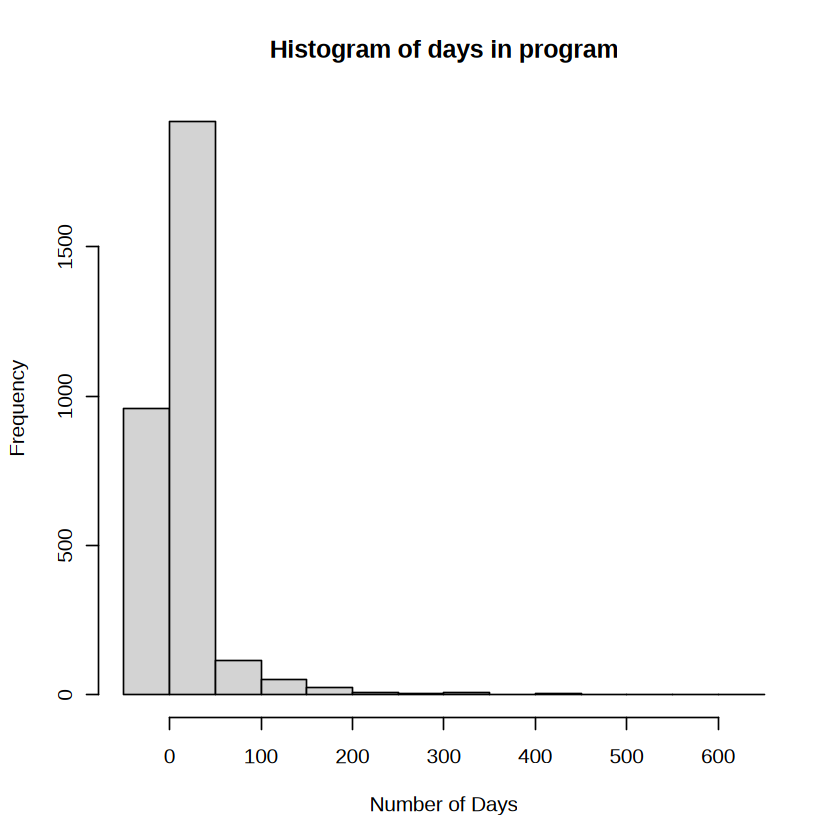

In [39]:
hist(fr_measures$days_in_program, main = "Histogram of days in program",xlab = 'Number of Days')

Next, let's look at the distribution for each of the frailty measures: lab, self assessment and the merged.

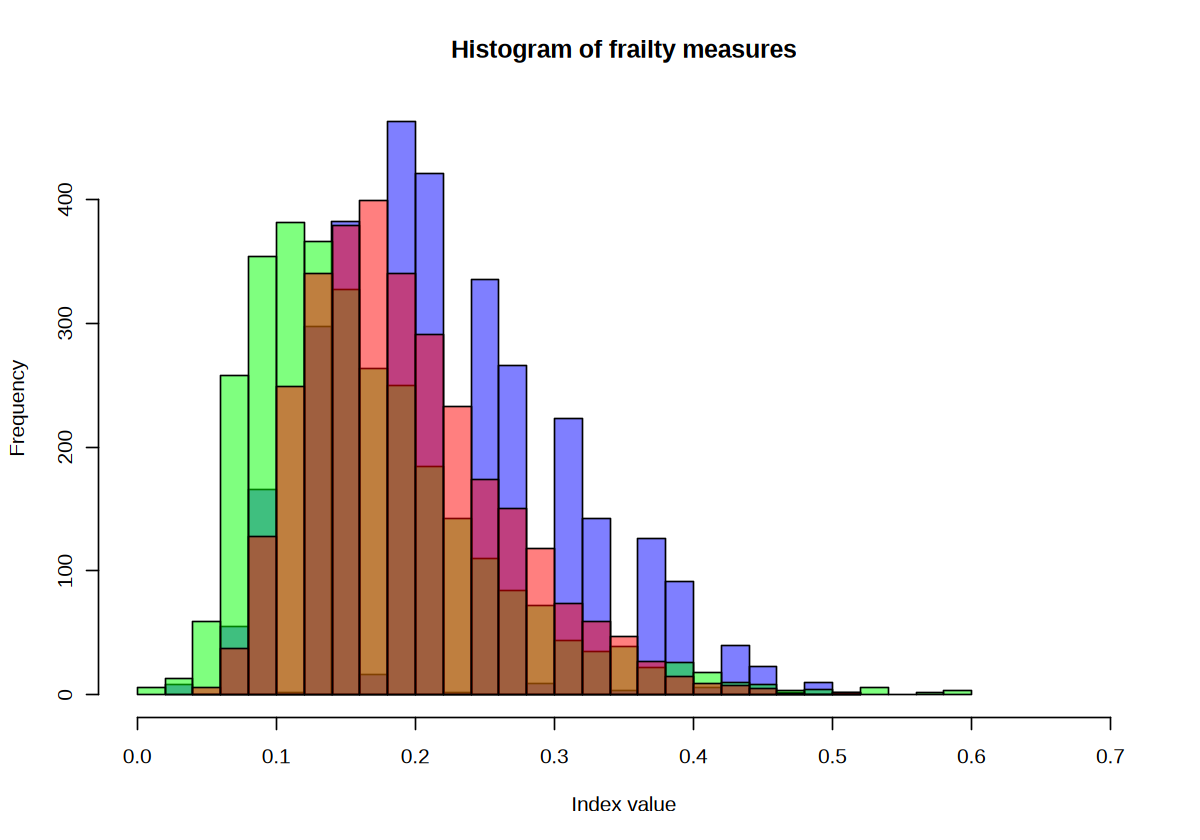

In [71]:
options(repr.plot.width=10, repr.plot.height=7)#Default=7x7
hist(fr_measures$lab_fi,  xlim=c(0,.7), col=rgb(0,0,1,2/4), breaks=25, main = "Histogram of frailty measures",xlab = 'Index value') # Blue
hist(fr_measures$self_fi, add=T, xlim=c(0,.7), col=rgb(0,1,0,2/4), breaks=25) # Green
hist(fr_measures$merge_fi, add=T, xlim=c(0,.7), col=rgb(1,0,0,2/4), breaks=25) # Red

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


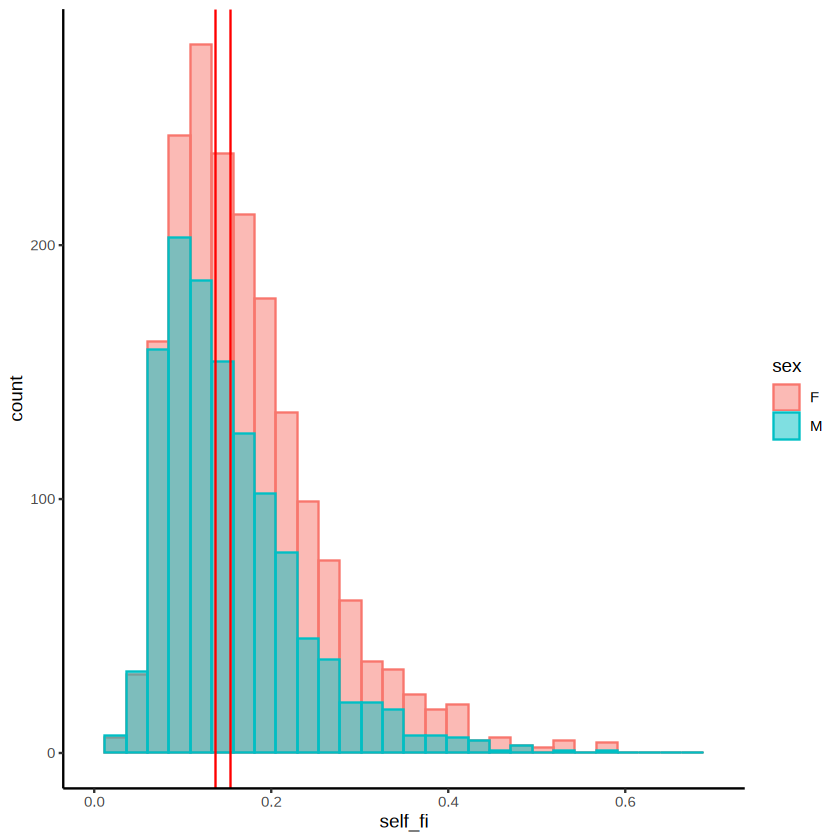

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


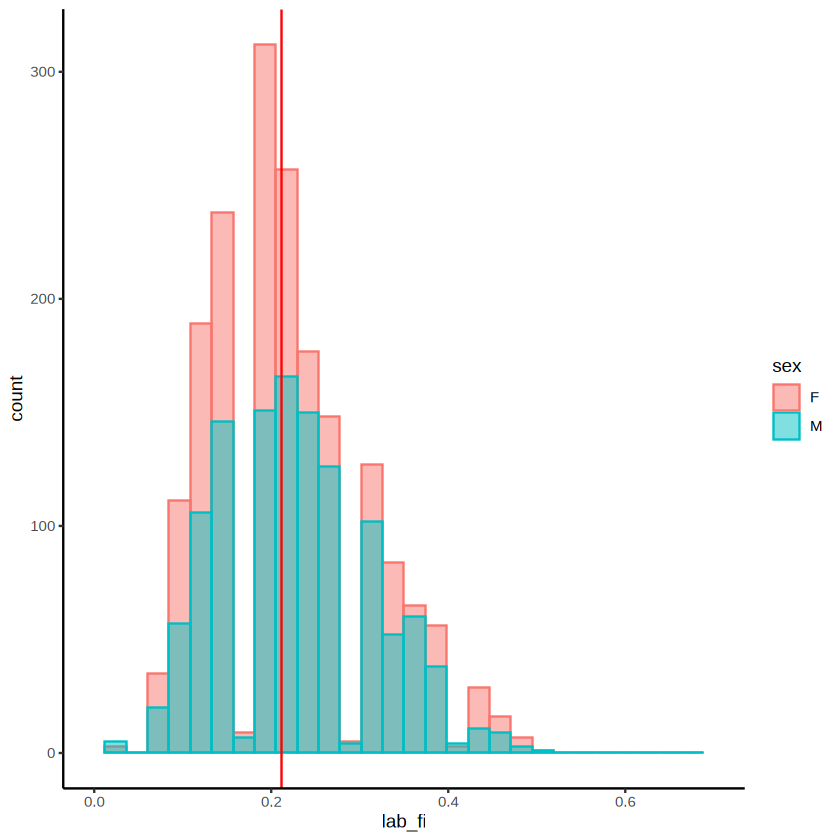

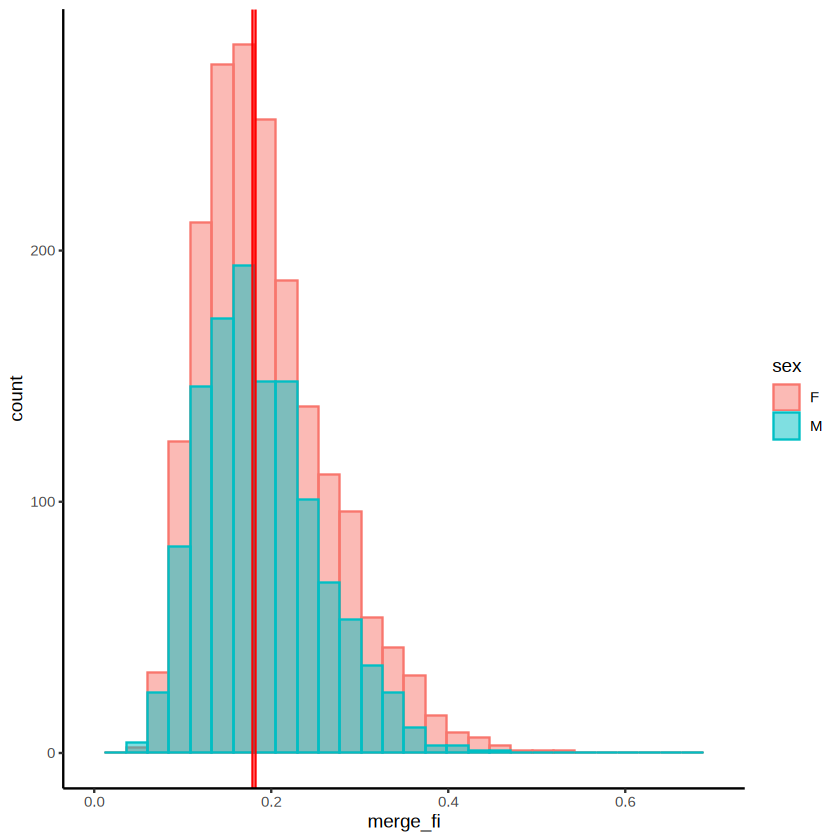

In [56]:
### CAN REMOVE
ggplot(fr_measures, aes(x=self_fi, color=sex, fill=sex)) +
    geom_histogram(position="identity", alpha=0.5)+
    geom_vline(xintercept = tapply(fr_measures$self_fi, fr_measures$sex, median), col = "red") +
    theme(legend.position="top") + xlim(0, .7) +
    theme_classic()

ggplot(fr_measures, aes(x=lab_fi, color=sex, fill=sex)) +
    geom_histogram(position="identity", alpha=0.5)+
    geom_vline(xintercept = tapply(fr_measures$lab_fi, fr_measures$sex, median), col = "red") +
    theme(legend.position="top") + xlim(0, .7) +
    theme_classic()

ggplot(fr_measures, aes(x=merge_fi, color=sex, fill=sex)) +
    geom_histogram(position="identity", alpha=0.5)+
    geom_vline(xintercept = tapply(fr_measures$merge_fi, fr_measures$sex, median), col = "red") +
    theme(legend.position="top") + xlim(0, .7) +
    theme_classic()

In [75]:
res <- do.call(rbind, by(fr_measures, function(x) { 
  rr <- with(x, cor.test(lab_fi, age, method="spearman")) 
  return(c(rr$estimate, CI=rr$conf.int)) 
})) 



ERROR: Error in do.call(rbind, by(fr_measures, list(fr_measures$sex), function(x) {: second argument must be a list


[1] "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M"
  [19] "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M"
  [37] "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M"
  [55] "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M"
  [73] "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M"
  [91] "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M"
 [109] "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M"
 [127] "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M"
 [145] "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M"
 [163] "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M"
 [181] "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M"
 [199] "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M"
 [217] "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M"
 [235] "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M"
 [253] "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M"
 [271] "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M"
 [289] "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M"
 [307] "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M"
 [325] "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M"
 [343] "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M"
 [361] "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M"
 [379] "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M"
 [397] "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M"
 [415] "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M"
 [433] "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M"
 [451] "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M"
 [469] "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M"
 [487] "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M"
 [505] "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M"
 [523] "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M"
 [541] "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M"
 [559] "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M"
 [577] "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M"
 [595] "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M"
 [613] "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M"
 [631] "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M"
 [649] "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M"
 [667] "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M"
 [685] "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M"
 [703] "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M"
 [721] "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M"
 [739] "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M"
 [757] "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M"
 [775] "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M"
 [793] "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M"
 [811] "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M"
 [829] "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M"
 [847] "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M"
 [865] "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M"
 [883] "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M"
 [901] "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M